In [35]:
import rasterio
import numpy as np
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from datetime import datetime
from skimage import morphology
from skimage.measure import label, regionprops

In [36]:
def get_neighborhood_features(tif_file, latitude, longitude, radius_km,):
    with rasterio.open(tif_file) as src:
        
        row, col = src.index(longitude, latitude)
        
        pixel_radius = radius_km / (src.res[0] * 500)  # 111 km per degree approximation
        
        window = rasterio.windows.Window(col - pixel_radius, row - pixel_radius, pixel_radius * 2, pixel_radius * 2)
        data = src.read(1, window=window)

        
        # Calculate spatial features
        mean_val = np.mean(data)
        sd_val = np.std(data)
        skewness_val = stats.skew(data, axis=None)
        kurtosis_val = stats.kurtosis(data, axis=None)
        
        # Calculate Texture Features
        glcm = graycomatrix(data.astype('uint8'), [1], [0], 256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        ASM = graycoprops(glcm, 'ASM')[0, 0]
        entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
        energy = graycoprops(glcm, 'energy')[0, 0]
        
    
        
        return {
            'mean': mean_val,
            'sd': sd_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'ASM': ASM,
            'entropy': entropy,
            'energy': energy,
            
        }

In [63]:
# Bangalore
#lat = 12.9767936
#long = 77.590082

#Sundarbans
lat = 21.9497
long = 89.1833

rad  = 40
lags = 4  # Number of lags to create
import os
tif_directory = "monthly/monthly-land-ers-geotiff"  # Replace with the actual folder path
tif_files = [f for f in os.listdir(tif_directory) if os.path.isfile(os.path.join(tif_directory, f)) and f.endswith('.tif')]

sorted_tif_files = sorted(tif_files)

import warnings
warnings.filterwarnings("ignore")

#from 1993-2000
features_df = pd.DataFrame()
for tif_file in sorted_tif_files[0:96]:
    date_str = tif_file.split('_')[5] +'_'+tif_file.split('_')[6].split('.tif')[0]# Adjust the index according to your file naming convention
    features = get_neighborhood_features(os.path.join(tif_directory, tif_file), latitude=lat, longitude=long, radius_km=rad)
    features_df = features_df.append({'date': date_str, **features}, ignore_index=True)
    
    
features_df.sort_values(by='date', inplace=True)


for lag in range(1, lags + 1):
    features_df[f'lag{lag}_mean'] = features_df['mean'].shift(lag)

# From 2001-2006
tif_directory = "monthly/monthly-land-quikscat-geotiff"  # Replace with the actual folder path
tif_files = [f for f in os.listdir(tif_directory) if os.path.isfile(os.path.join(tif_directory, f)) and f.endswith('.tif')]

sorted_tif_files = sorted(tif_files)
features_df1 = pd.DataFrame()
for tif_file in sorted_tif_files[0:72]:
    date_str = tif_file.split('_')[5] +'_'+tif_file.split('_')[6].split('.tif')[0]# Adjust the index according to your file naming convention
    features = get_neighborhood_features(os.path.join(tif_directory, tif_file), latitude=lat, longitude=long, radius_km=rad)
    features_df1 = features_df1.append({'date': date_str, **features}, ignore_index=True)
    
    
features_df1.sort_values(by='date', inplace=True)

for lag in range(1, lags + 1):
    features_df1[f'lag{lag}_mean'] = features_df1['mean'].shift(lag)

# from 2006-2020     
tif_directory = "monthly/monthly-land-ascat-geotiff"  # Replace with the actual folder path
tif_files = [f for f in os.listdir(tif_directory) if os.path.isfile(os.path.join(tif_directory, f)) and f.endswith('.tif')]

sorted_tif_files = sorted(tif_files)    
features_df2 = pd.DataFrame()
for tif_file in sorted_tif_files[0:168]:
    date_str = tif_file.split('_')[5] +'_'+tif_file.split('_')[6].split('.tif')[0]# Adjust the index according to your file naming convention
    features = get_neighborhood_features(os.path.join(tif_directory, tif_file), latitude=lat, longitude=long, radius_km=rad)
    features_df2 = features_df2.append({'date': date_str, **features}, ignore_index=True)
    
    
features_df2.sort_values(by='date', inplace=True)
for lag in range(1, lags + 1):
    features_df2[f'lag{lag}_mean'] = features_df2['mean'].shift(lag)    
   


In [64]:
main_df = pd.concat([features_df, features_df1, features_df2], axis=0)

In [65]:
main_df[['Year', 'Month']] = main_df['date'].str.split('_', 1, expand=True)

# Convert to integers
main_df['Year'] = main_df['Year'].astype(int)
main_df['Month'] = main_df['Month'].astype(int)

# Drop the original 'data' column
main_df = main_df.drop('date', axis=1)

# Rearrange columns
main_df = main_df[['Year', 'Month'] + [col for col in main_df.columns if col not in ['Year', 'Month']]]

In [66]:
main_df

,Year,Month,mean,sd,skewness,kurtosis,contrast,dissimilarity,homogeneity,ASM,entropy,energy,lag1_mean,lag2_mean,lag3_mean,lag4_mean
0,1993,1,-9.852119,0.302629,0.445980,-1.001486,0.166667,0.166667,0.916667,0.375000,1.625815,0.612372,NaN,NaN,NaN,NaN
1,1993,2,-9.963833,0.303067,0.537415,-1.015736,0.166667,0.166667,0.916667,0.375000,1.625815,0.612372,-9.852119,NaN,NaN,NaN
2,1993,3,-9.856525,0.208361,0.697576,-0.493119,0.000000,0.000000,1.000000,0.555556,0.918296,0.745356,-9.963833,-9.852119,NaN,NaN
3,1993,4,-9.925649,0.290035,0.668068,-0.412510,0.166667,0.166667,0.916667,0.375000,1.625815,0.612372,-9.856525,-9.963833,-9.852119,NaN
4,1993,5,-9.439488,0.247958,0.686531,-0.461153,0.166667,0.166667,0.916667,0.708333,0.816689,0.841625,-9.925649,-9.856525,-9.963833,-9.852119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020,8,-9.177175,0.324353,-1.300931,0.695765,0.333333,0.333333,0.833333,0.333333,1.792481,0.577350,-9.299584,-9.354208,-9.618473,-9.699369
164,2020,9,-9.253255,0.335678,-1.160853,0.384615,0.333333,0.333333,0.833333,0.305556,2.125815,0.552771,-9.177175,-9.299584,-9.354208,-9.618473
165,2020,10,-9.099824,0.338879,-0.784109,0.038586,0.166667,0.166667,0.916667,0.375000,1.625815,0.612372,-9.253255,-9.177175,-9.299584,-9.354208
166,2020,11,-9.206432,0.320749,-0.850198,0.046822,0.166667,0.166667,0.916667,0.486111,1.418296,0.697217,-9.099824,-9.253255,-9.177175,-9.299584


In [67]:
import os
import pandas as pd


notebook_directory = os.path.dirname(os.path.abspath("Project.ipynb"))
csv_file_path = os.path.join(notebook_directory, 'main_df.csv')
main_df.to_csv(csv_file_path, index=False)
print(f"main_df has been saved to {csv_file_path}")


main_df has been saved to /Users/pavan/Documents/CSE 881/main_df.csv


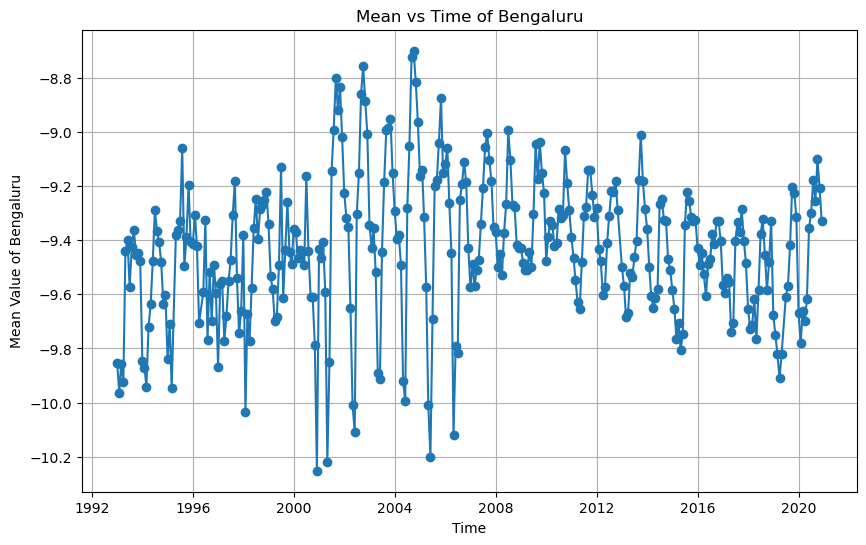

In [68]:
import matplotlib.pyplot as plt
main_df['Date'] = pd.to_datetime(main_df[['Year', 'Month']].assign(DAY=1))

filtered_df = main_df[main_df['mean'] >= -50]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], filtered_df['mean'], marker='o', linestyle='-')
plt.title('Mean vs Time of Bengaluru')
plt.xlabel('Time')
plt.ylabel('Mean Value of Bengaluru')
plt.grid(True)
plt.show()

In [78]:
from geopy.geocoders import Nominatim

def get_lat_long(city):
    geolocator = Nominatim(user_agent="city_locator")
    location = geolocator.geocode(city)
    if location:
        return location.latitude, location.longitude
    else:
        return None

def get_city_coordinates_dict(cities):
    city_coordinates = {}

    for city in cities:
        coordinates = get_lat_long(city)
        if coordinates:
            city_coordinates[city] = coordinates
        else:
            print(f"Unable to fetch coordinates for {city}")

    return city_coordinates

def main():
    cities = ["Mumbai", "Delhi", "Bengaluru", "Chennai", "Kolkata", "Hyderabad", "Ahmedabad", "Pune", "Surat", "Jaipur"]

    # Create a dictionary for city coordinates
    city_coordinates_dict = get_city_coordinates_dict(cities)

    print("City\t\t\tLatitude\tLongitude")
    print("="*40)

    for city, coordinates in city_coordinates_dict.items():
        print(f"{city: <15}\t{coordinates[0]:.4f}\t\t{coordinates[1]:.4f}")
        
    return city_coordinates_dict

    # You can now use 'city_coordinates_dict' for future purposes
    # For example, accessing coordinates for a specific city:
    # print("Coordinates for Mumbai:", city_coordinates_dict["Mumbai"])

if __name__ == "__main__":
    city_coordinates_dict = main()


City			Latitude	Longitude
Mumbai         	18.9734		72.8281
Delhi          	28.6274		77.1717
Bengaluru      	12.9768		77.5901
Chennai        	13.0837		80.2702
Kolkata        	22.5726		88.3639
Hyderabad      	17.3606		78.4741
Ahmedabad      	23.0216		72.5797
Pune           	18.5214		73.8545
Surat          	45.9383		3.2553
Jaipur         	26.9155		75.8190
